## Setup

In [1]:
# run in forrestwilliams/gis:1.03
%matplotlib inline
import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
from shapely import geometry
from pathlib import Path
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix, mean_absolute_error
from itertools import product

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from matplotlib.patches import Patch, Polygon, Circle, Rectangle
import matplotlib.colors as colors
from matplotlib.lines import Line2D

In [2]:
cd /home/micromamba/data

/home/micromamba/data


In [3]:
save_dir = Path('/home/micromamba/figures_tables')

In [4]:
def round_to(n, precision):
    correction = 0.5 if n >= 0 else -0.5
    return int( n/precision+correction ) * precision

def format_axis(axis,xlim,ylim,step=1,places=0,show_axis=True):
        
    axis.set(xlim=xlim,ylim=ylim)
    
    if show_axis:
        xticks = np.arange(round_to(xlim[0],step)+step, xlim[1],step)
        yticks = np.arange(round_to(ylim[0],step)+step, ylim[1],step)
        
        axis.set(xticks=xticks,yticks=yticks)

        if xlim[0] > 0:
            xdir = 'W'
        else:
            xdir = 'E'

        if ylim[0] > 0:
            ydir = 'N'
        else:
            ydir = 'S'

        xlabels = [f'{round(abs(x),places)}$\degree${xdir}' for x in xticks]
        ylabels = [f'{round(abs(x),places)}$\degree${ydir}' for x in yticks]

        axis.set_xticklabels(xlabels)
        axis.set_yticklabels(ylabels)
    
    else:
        axis.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
    
    return axis

def add_north_arrow(axis,x=0.06, y=0.96, arrow_length=0.1, color='black'):
    axis.annotate('N', xy=(x, y), xytext=(x, y-arrow_length), color=color,
            arrowprops=dict(color=color, width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=axis.transAxes)
    return axis

def add_scale_bar(axis,width=100,height=15,label='100 m',loc='lower right',color='black',frameon=False):
    scalebar = AnchoredSizeBar(axis.transData, width, label, loc,
                           pad=0.1,
                           size_vertical=height,
                           color=color,
                           frameon=frameon,
                           label_top=True)

    axis.add_artist(scalebar)
    return axis

def read_raster(path,bands=1,rgb=False,resample_factor=None):
    with rio.open(path) as dst:
        crs = dst.crs
        extent = plotting_extent(dst)
        
        if resample_factor:
            out_shape=(dst.count,int(dst.height * resample_factor),int(dst.width * resample_factor))
            data = dst.read(out_shape=out_shape,resampling=Resampling.bilinear)
        else:
            data = dst.read(bands)

    if rgb:
        data = np.moveaxis(data,0,-1)

    return (data, crs, extent)

def get_zero_ifg_date_ranges(ifgs):
    # find the gaps
    n_ifgs = pd.DataFrame({'n_valid':0},index=pd.date_range(ifgs.date1.min(),ifgs.date2.max()))

    for i,row in ifgs.iterrows():
        date_range = pd.date_range(row.date1,row.date2)
        if row.coherence > 0.4:
            n_ifgs.loc[n_ifgs.index.isin(date_range),'n_valid'] += 1

        zero = n_ifgs.loc[n_ifgs.n_valid<1].copy()
        date = pd.Series(zero.index)
        offset = [0] + list((zero.index[1:] - zero.index[:-1]).days)
        jumps = [0]+[x for x,y in enumerate(offset) if y > 1] + [len(zero)]

        intervals = pd.DataFrame(columns=['start','end','length'])
        for i in range(len(jumps)-1):
            d1 = zero.index[jumps[i]]
            d2 = zero.index[jumps[i+1]-1]
            length = d2-d1
            intervals = intervals.append({'start':d1,'end':d2,'length':length},ignore_index=True)

    return n_ifgs, intervals

In [5]:
# Read in important datasets
test_set = gpd.read_file('activity_measures_c90_ms10_std2.geojson')
pegs = gpd.read_file('pot_rate_comparison.geojson')
asc = pd.read_csv('ascending_ifgs.csv')
desc = pd.read_csv('descending_ifgs.csv')

pegs_sub = pegs.loc[~((pegs.location=='bird')&(pegs.name=='Peg 22') |
        (pegs.location=='rangitikei')&(pegs.name=='Peg 21'))]

## Important Numbers

### Active landslide dataset area by type

In [47]:
test_set.groupby('active')['area_ha'].min()

active
0    10.017557
1    12.283491
Name: area_ha, dtype: float64

In [49]:
test_set.groupby('active')['area_ha'].median()

active
0    23.471931
1    56.509988
Name: area_ha, dtype: float64

In [12]:
test_set.groupby('active')['area_ha'].sum()

active
0    1775.004163
1     818.577096
Name: area_ha, dtype: float64

### Double difference temporal coherence effect

In [6]:
tcoh_desc_2019_vanilla, _, _ = read_raster('temporalCoherence_desc_2019_vanilla.tif')
tcoh_asc_2019_vanilla, _, _ = read_raster('temporalCoherence_asc_2019_vanilla.tif')

tcoh_desc_2019_filtered, _, _ = read_raster('temporalCoherence_desc_2019.tif')
tcoh_asc_2019_filtered, _, _ = read_raster('temporalCoherence_asc_2019.tif')

In [7]:
vanilla_desc_mean = np.nanmean(tcoh_desc_2019_vanilla.flatten())
vanilla_asc_mean = np.nanmean(tcoh_asc_2019_vanilla.flatten())

filtered_desc_mean = np.nanmean(tcoh_desc_2019_filtered.flatten())
filtered_asc_mean = np.nanmean(tcoh_asc_2019_filtered.flatten())

vanilla_mean = (vanilla_desc_mean + vanilla_asc_mean) / 2
filtered_mean = (filtered_desc_mean + filtered_asc_mean) / 2

print(f'tcoh vanilla: {vanilla_mean:.3f}')
print(f'tcoh filtered: {filtered_mean:.3f}')

tcoh vanilla: 0.664
tcoh filtered: 0.904


In [16]:
del tcoh_desc_2019_vanilla
del tcoh_asc_2019_vanilla
del tcoh_desc_2019_filtered
del tcoh_asc_2019_filtered

### % of pixels identified as active by standard deviation filter

In [8]:
std_desc, _, _ = read_raster('std_desc_2019.tif')
std_asc, _, _ = read_raster('std_asc_2019.tif')

velcoh_desc, _, _ = read_raster('velcoh_desc_2019.tif')
velcoh_asc, _, _ = read_raster('velcoh_asc_2019.tif')

In [9]:
n_desc = np.nansum(~np.isnan(tcoh_desc_2019_filtered))
n_desc_std = np.nansum(~np.isnan(std_desc))
n_desc_velcoh = np.nansum(~np.isnan(velcoh_desc))

n_asc = np.nansum(~np.isnan(tcoh_asc_2019_filtered))
n_asc_std = np.nansum(~np.isnan(std_asc))
n_asc_velcoh = np.nansum(~np.isnan(velcoh_asc))

prop_std = ((n_desc_std / n_desc) + (n_asc_std / n_asc)) / 2
prop_velcoh = ((n_desc_velcoh / n_desc) + (n_asc_velcoh / n_asc)) / 2

print(f'% activity using std filter: {prop_std:.3f}')
print(f'% activity using velcoh filter: {prop_velcoh:.3f}')

% activity using std filter: 0.604
% activity using velcoh filter: 0.005


### Combined filter metrics

In [10]:
from scipy import ndimage

In [11]:
velcoh_combo, _, _ = read_raster('velcoh_combined_2019.tif')

In [12]:
binary = velcoh_combo != 0
labels, n = ndimage.label(binary)
objects = ndimage.find_objects(labels)

In [13]:
counts = pd.DataFrame(columns=['zone','count'])

for i,s in enumerate(objects):
    window = labels[s].copy()
    count = np.nansum(window==(i+1))
    counts = counts.append({'zone':i+1,'count':count},ignore_index=True)

[(0.0, 200.0), (0.0, 3000.0)]

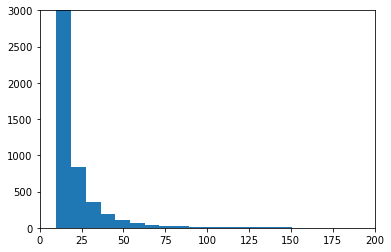

In [20]:
f, ax = plt.subplots(1,1)
ax.hist(counts['count'],bins=100)
ax.set(xlim=(0,200),ylim=(0,3000))

In [91]:
size_median = counts['count'].median() * (40*40) / 10000
size_max = counts['count'].max() * (40*40) / 10000
n_combo = np.nansum(~np.isnan(tcoh_desc_2019_filtered) & ~np.isnan(tcoh_asc_2019_filtered))
prop_combo = np.nansum(binary) / n_combo

In [92]:
print(f'n clusters: {n:.0f}')
print(f'Median cluster size: {size_median:.2f} ha')
print(f'Max cluster size: {size_max:.2f} ha')
print(f'% of study area {prop_combo:.3f} ha')

n clusters: 4825
Median cluster size: 2.40 ha
Max cluster size: 142.08 ha
% of study area 0.011 ha


### Peg movement rate stats

In [55]:
import rasterstats

In [74]:
pegs_insar = pegs.copy()

In [75]:
insar_ew_vel = rasterstats.zonal_stats(pegs_insar.geometry.buffer(20),
                                       'velocity_ew_2019.tif',stats=['mean'],nodata=0)

In [79]:
pegs_insar['insar_e_rate'] = [x['mean'] for x in insar_ew_vel]
pegs_insar['insar_e_rate'] *= -1

In [80]:
cols = ['e_rate', 'insar_e_rate','location']

In [82]:
pegs_insar[cols].groupby('location').mean()

e_rate  insar_e_rate
location                          
bird        1.615734      0.030043
rangitikei  0.215874     -0.006434

In [83]:
pegs_insar[cols].groupby('location').max()

e_rate  insar_e_rate
location                          
bird        3.435243       0.06363
rangitikei  3.303934       0.03949

## Tables

### Table InSAR

In [55]:
gdf = test_set.copy()

trials = [x for x in gdf.columns if ('bekaert' in x) | ('velcoh' in x)]

tmp = gdf[['name','active'] + trials]
cols = tmp.columns

# Desired architecture:
# landslide year active type value

df = tmp.melt(id_vars=cols[0:2],value_vars=cols[2:],value_name='prediction')
df[['method','direction','year']] = df.variable.str.split('_',expand=True)
df['type'] = df.method + '_' + df.direction
df['year'] = df.year.astype(int)

cols = ['type','true_neg','true_pos','kappa','acc']
metrics = pd.DataFrame(columns=cols)

for t in df.type.unique():
    sel = df.loc[df.type == t].copy()

    conf = confusion_matrix(sel.active,sel.prediction)
    kappa = cohen_kappa_score(sel.active,sel.prediction)
    acc = accuracy_score(sel.active,sel.prediction)
    
    metrics = metrics.append(dict(zip(cols,[t,conf[0,0],conf[1,1],kappa,acc])),ignore_index=True)

In [53]:
metrics['true_neg'] = metrics.true_neg / (gdf.active == 0).sum()
metrics['true_pos'] = metrics.true_pos / (gdf.active == 1).sum()

In [56]:
orbits = {'asc':'ascending','desc':'descending','both':'combination'}
filters = {'bekaert':'standard deviation','velcoh':'velocity coherence'}

metrics[['filter','orbit']] = metrics['type'].str.split('_',1,expand=True)

metrics['orbit'] = metrics['orbit'].map(orbits)
metrics['filter'] = metrics['filter'].map(filters)

metrics = metrics[['filter', 'orbit', 'true_neg', 'true_pos', 'acc', 'kappa']]

In [57]:
metrics.sort_values(['filter','orbit'])

filter        orbit true_neg true_pos       acc     kappa
1  standard deviation    ascending        6       11  0.283333  0.018265
0  standard deviation   descending       13       10  0.383333  0.051282
3  velocity coherence    ascending       46        8  0.900000  0.666667
4  velocity coherence  combination       44       11  0.916667  0.761905
2  velocity coherence   descending       46        9  0.916667  0.731183

### Table Pixel Offset

In [35]:
po_error = pd.DataFrame(columns=['Site', 'Rate', 'N', 'Average Rate (m/yr)', 'MAE (m/yr)'])
groups = {'All':[-np.inf,np.inf],'< 1 m/yr':[-np.inf,1],'> 1 m/yr':[1,np.inf]}
sites = {'Rangitikei':['rangitikei'],'Bird':['bird'],'Both':['rangitikei','bird']}

for s,g in product(sites,groups):
    min_val,max_val = groups[g]
    loc = sites[s]
    tmp = pegs_sub.loc[(pegs_sub.mag_rate>min_val) & (pegs_sub.mag_rate<max_val) & pegs_sub.location.isin(loc)]
    
    avg_rate = tmp.mag_rate.mean()
    mae = mean_absolute_error(tmp.mag_rate, tmp.po_mag_rate)
    
    row = {'Site':s, 'Rate':g, 'N':tmp.shape[0], 'Average Rate (m/yr)':avg_rate, 'MAE (m/yr)':mae}
    po_error = po_error.append(row,ignore_index=True)

In [36]:
po_error

Site      Rate   N  Average Rate (m/yr)  MAE (m/yr)
0  Rangitikei       All  25             0.946923    0.765447
1  Rangitikei  < 1 m/yr  19             0.252128    0.799248
2  Rangitikei  > 1 m/yr   6             3.147106    0.658408
3        Bird       All  17             2.877358    0.992895
4        Bird  < 1 m/yr   2             0.644236    0.848284
5        Bird  > 1 m/yr  15             3.175107    1.012177
6        Both       All  42             1.728289    0.857509
7        Both  < 1 m/yr  21             0.289472    0.803918
8        Both  > 1 m/yr  21             3.167107    0.911100

## Figures

### Figure Pixel Offset Residual

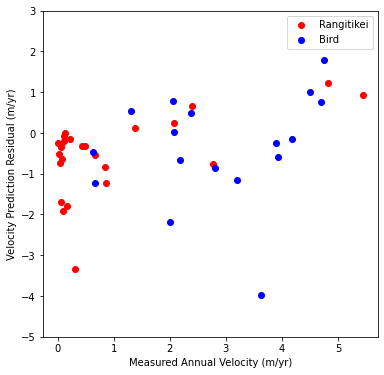

In [88]:
f, ax = plt.subplots(1,1,figsize=(6,6))

locs = {'rangitikei':'red','bird':'blue'}

for loc in locs:
    color = locs[loc]
    tmp = pegs_sub.loc[pegs_sub.location == loc]
    ax.scatter(tmp.mag_rate,tmp.mag_rate - tmp.po_mag_rate, color=color, label=loc.capitalize())

ax.set(ylim=(-5,3),xlabel='Measured Annual Velocity (m/yr)',ylabel='Velocity Prediction Residual (m/yr)')
ax.legend()
plt.savefig(save_dir / 'po_residual.png',dpi=300,bbox_inches='tight')

### Figure Rose Plot

In [13]:
rose = test_set.loc[test_set.active==1,['active','velcoh_asc_2019','velcoh_desc_2019','aspect','area_ha']].copy()
rose['code'] = (rose.velcoh_asc_2019 * 10) + rose.velcoh_desc_2019
labels = {11:'Both Correct',10:'Ascending Correct',1:'Descending Correct',0:'Neither Correct'}
colors = {11:'green',10:'yellow',1:'blue',0:'red'}

# rose = test_set.loc[test_set.active>-1,['active','aspect','area_ha']].copy()
# rose['code'] = rose.active
# classes = {1:'Active',0:'Non-active'}
# colors = {1:'red',0:'green'}

rose['label'] = rose['code'].map(labels)
rose['color'] = rose['code'].map(colors)
rose = rose.sort_values('code').reset_index(drop=True)

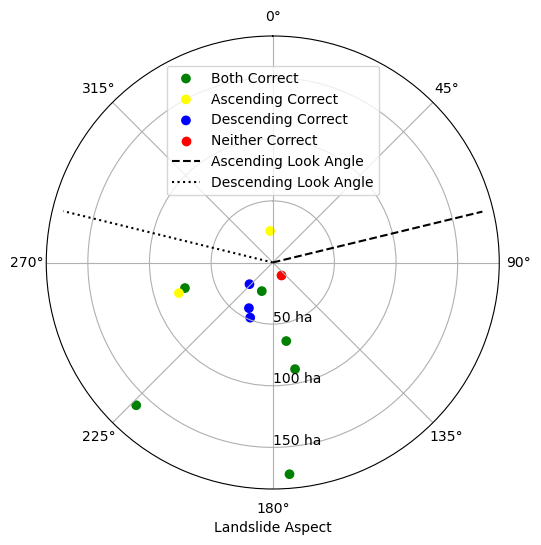

In [45]:
width = np.deg2rad(1.5)

fig = plt.figure(figsize=(6,6),dpi=100)
ax = fig.add_subplot(projection='polar')
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_xlabel('Landslide Aspect')
# ax.set_ylabel('Area (ha)')
ax.set_rticks([50,100,150],labels=['50 ha','100 ha','150 ha'])
ax.set_rlabel_position(180)

for label in labels.values():
    df = rose.loc[rose.label==label].copy()
    ax.scatter(np.deg2rad(df.aspect), df.area_ha, c=df.color, label=label)

ax.vlines(np.deg2rad(-13.64+90),0,175,color='black',linestyles='dashed',label='Ascending Look Angle')
ax.vlines(np.deg2rad(-166.22+90),0,175,color='black',linestyles='dotted',label='Descending Look Angle')
ax.legend(loc='upper center',bbox_to_anchor=(0.5,0.95))
plt.savefig(save_dir / 'aspect.png',dpi=300,bbox_inches='tight')

### Figure Rangitikei Pegs

In [13]:
rang = pegs.loc[pegs.location=='rangitikei']

landslide_rang, crs_rang, extent_rang = read_raster('imagery/horizons_rangitikei.tif',bands=[1,2,3],rgb=True)

po_rang_ns, _, po_rang_extent = read_raster('rangitikei_velocity_ns.tif',bands=1)
po_rang_ew, _, _ = read_raster('rangitikei_velocity_ew.tif',bands=1)

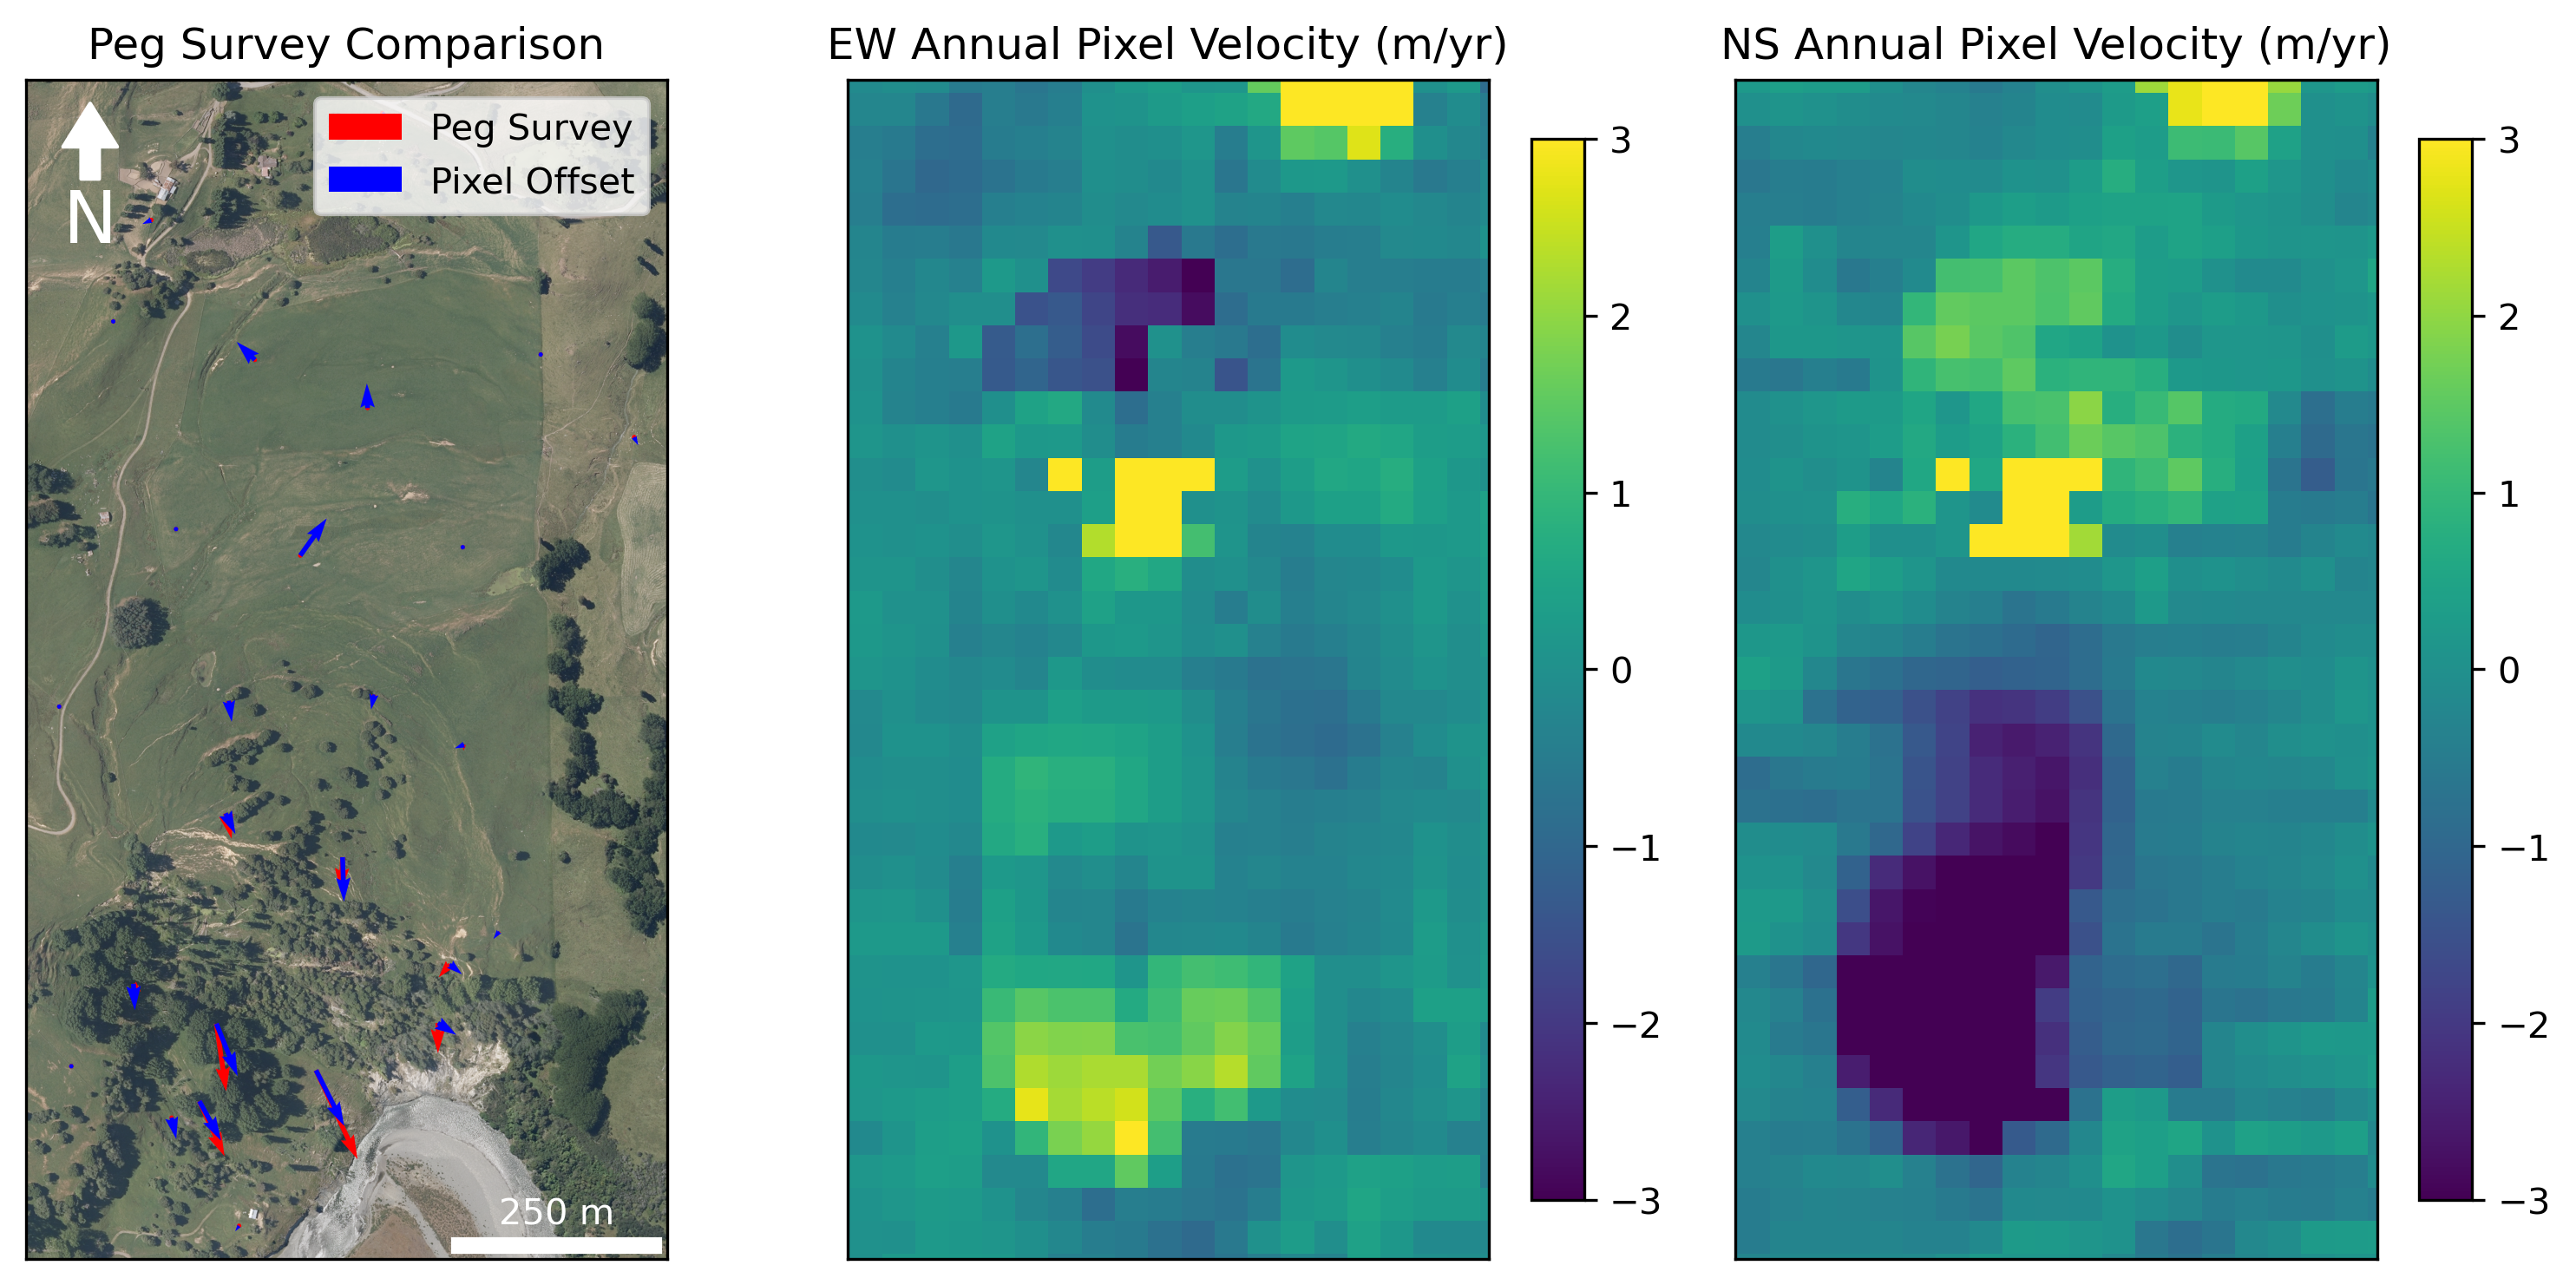

In [15]:
# Setup
b = 40
w, e, s, n = [rang.east.min()-b,rang.east.max()+b,rang.north.min()-b,rang.north.max()+b]
options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,6),dpi=300)

# Pegs
ax1.quiver(rang.east, rang.north, rang.e_rate, rang.n_rate,color='red',label='Peg Survey',**options)
ax1.quiver(rang.east, rang.north, rang.po_e_rate, rang.po_n_rate,color='blue',label='Pixel Offset',**options)
ax1.imshow(landslide_rang,extent=extent_rang,interpolation=None)

ax1.legend(loc='upper right', frameon=True)

ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Peg Survey Comparison')

# EW
ew_plot = ax2.imshow(po_rang_ew,extent=po_rang_extent,interpolation=None,vmin=-3,vmax=3)
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2.set_title('EW Annual Pixel Velocity (m/yr)')

# NS
ns_plot = ax3.imshow(po_rang_ns,extent=po_rang_extent,interpolation=None,vmin=-3,vmax=3)
ax3 = format_axis(ax3,xlim=(w,e),ylim=(s,n),show_axis=False)
ax3.set_title('NS Annual Pixel Velocity (m/yr)')

fig.colorbar(ew_plot, ax=ax2, shrink=0.9)
fig.colorbar(ns_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(save_dir / 'pegs_rang.png',dpi=300,bbox_inches='tight')

In [16]:
del landslide_rang, po_rang_ns, po_rang_ew

### Figure Bird Pegs

In [6]:
bird = pegs.loc[pegs.location=='bird']

landslide_bird, crs_bird, extent_bird = read_raster('imagery/horizons_bird.tif',bands=[1,2,3],rgb=True)

po_bird_ns, _, po_bird_extent = read_raster('bird_velocity_ns.tif',bands=1)
po_bird_ew, _, _ = read_raster('bird_velocity_ew.tif',bands=1)

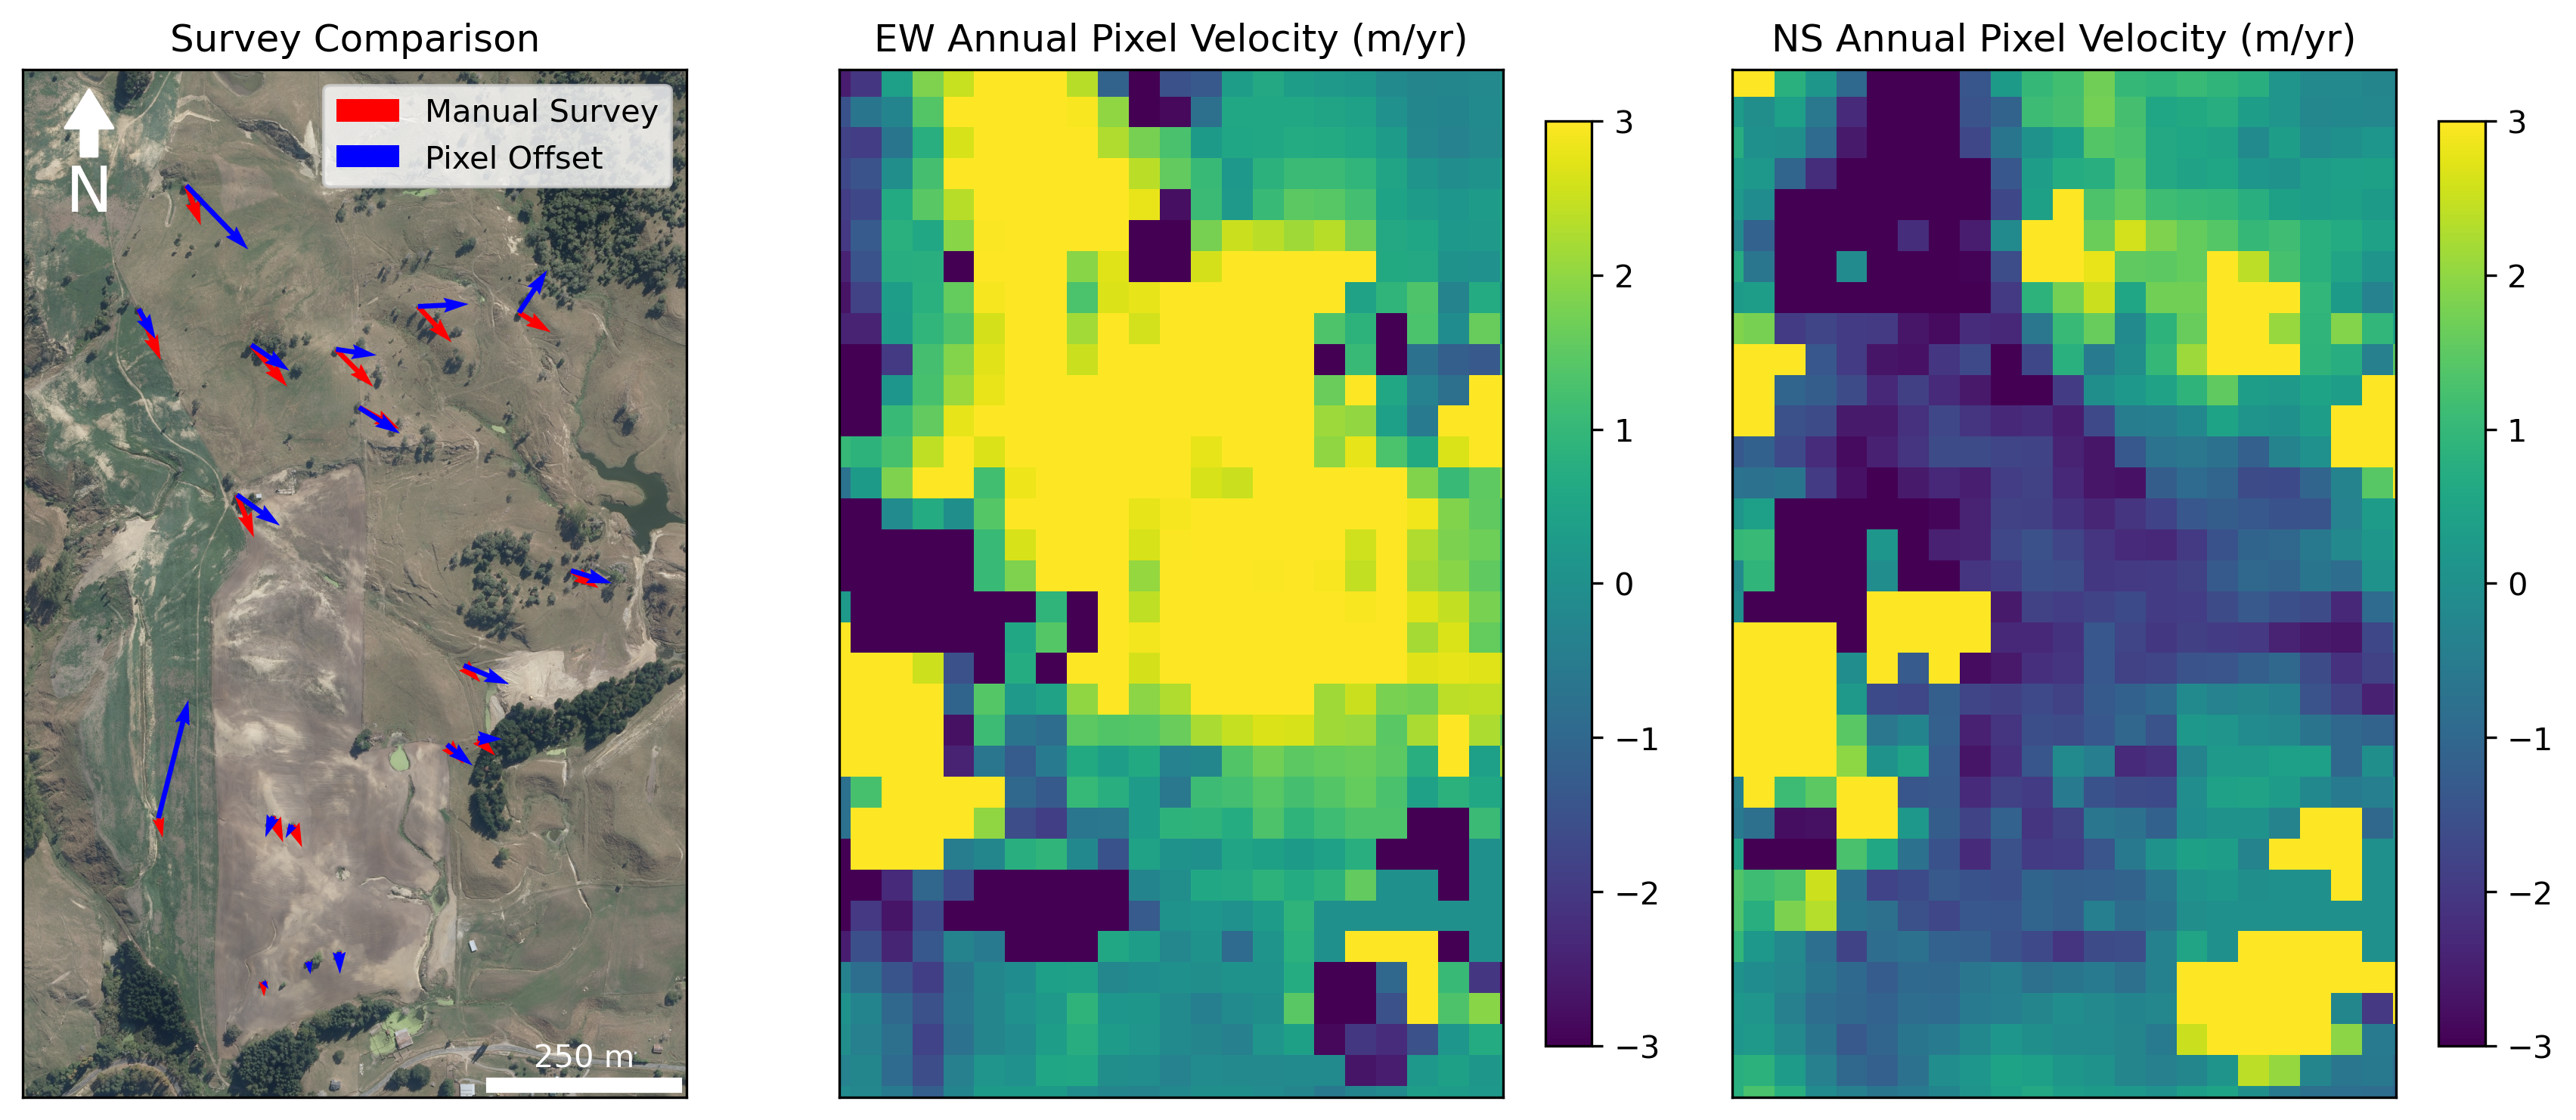

In [7]:
# Setup
b = 150
w, e, s, n = [bird.east.min()-b,bird.east.max()+b,bird.north.min()-b,bird.north.max()+b]
options = dict(angles='xy',scale_units='xy',scale=0.066,width=0.0075)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,6),dpi=300)

# Pegs
ax1.quiver(bird.east, bird.north, bird.e_rate, bird.n_rate,color='red',label='Manual Survey',**options)
ax1.quiver(bird.east, bird.north, bird.po_e_rate, bird.po_n_rate,color='blue',label='Pixel Offset',**options)
ax1.imshow(landslide_bird,extent=extent_bird,interpolation=None)

ax1.legend(loc='upper right', frameon=True)

ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Survey Comparison')

# EW
ew_plot = ax2.imshow(po_bird_ew,extent=po_bird_extent,interpolation=None,vmin=-3,vmax=3)
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2.set_title('EW Annual Pixel Velocity (m/yr)')

# NS
ns_plot = ax3.imshow(po_bird_ns,extent=po_bird_extent,interpolation=None,vmin=-3,vmax=3)
ax3 = format_axis(ax3,xlim=(w,e),ylim=(s,n),show_axis=False)
ax3.set_title('NS Annual Pixel Velocity (m/yr)')

fig.colorbar(ew_plot, ax=ax2, shrink=0.9)
fig.colorbar(ns_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(save_dir / 'pegs_bird.png',dpi=300,bbox_inches='tight')

In [8]:
del landslide_bird, po_bird_ns, po_bird_ew

### Figure Active/Inactive

In [17]:
landslide_active, crs_active, extent_active = read_raster('imagery/horizons_landslide_846.tif',bands=[1,2,3],rgb=True)
landslide_inactive, crs_inactive, extent_inactive = read_raster('imagery/horizons_landslide_807.tif',bands=[1,2,3],rgb=True)

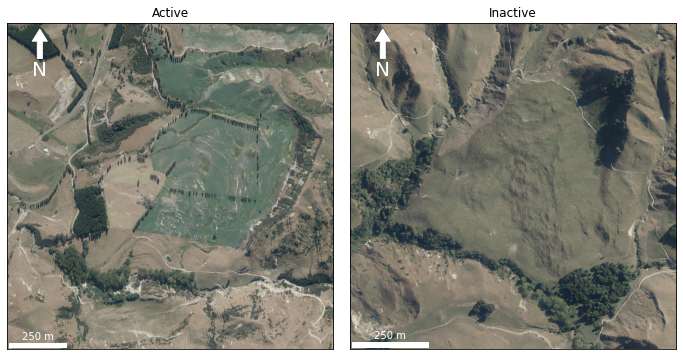

In [18]:
# Setup
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))#,gridspec_kw={'width_ratios':[1.15,1]})
b = 0

# Active
b = 0
w,e,s,n = extent_active
ax1.imshow(landslide_active,extent=extent_active,interpolation=None)
ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.125,color='white')
ax1 = add_scale_bar(ax1,width=250,loc='lower left',label='250 m',color='white')
ax1.set_title('Active')

# Inactive
b = 0
w,e,s,n = extent_inactive
ax2.imshow(landslide_inactive,extent=extent_inactive,interpolation=None)
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2 = add_north_arrow(ax2,x=0.1, y=0.98, arrow_length=0.125,color='white')
ax2 = add_scale_bar(ax2,width=250,loc='lower left',label='250 m',color='white')
ax2.set_title('Inactive')

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(save_dir / 'active_inactive.png',dpi=300,bbox_inches='tight')

In [19]:
del landslide_active, landslide_inactive

### Figure InSAR PO Comparison

In [9]:
rang = pegs.loc[pegs.location=='rangitikei']
landslide_rang, crs_rang, extent_rang = read_raster('imagery/horizons_rangitikei.tif',bands=[1,2,3],rgb=True)

po_rang_ew, _, po_rang_extent = read_raster('rangitikei_velocity_ew.tif',bands=1)
insar_rang_ew, _, insar_rang_extent = read_raster('velocity_ew_2019.tif',bands=1)

insar_rang_ew = -1*insar_rang_ew #direction was accidentally reversed

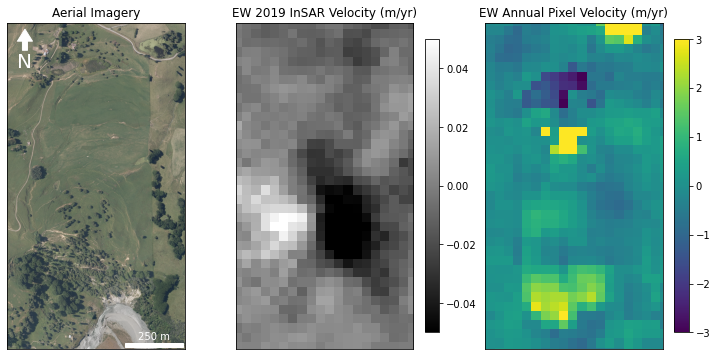

In [14]:
# Setup
b = 40
w, e, s, n = [rang.east.min()-b,rang.east.max()+b,rang.north.min()-b,rang.north.max()+b]

f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(13,6))

# Imagery
ax1.imshow(landslide_rang,extent=extent_rang,interpolation=None)

ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Aerial Imagery')

# InSAR EW
insar_plot = ax2.imshow(insar_rang_ew,extent=insar_rang_extent,interpolation=None,vmin=-0.05,vmax=0.05,cmap='gray')
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2.set_title('EW 2019 InSAR Velocity (m/yr)')

# Pixel EW
pixel_ew_plot = ax3.imshow(po_rang_ew,extent=po_rang_extent,interpolation=None,vmin=-3,vmax=3)
ax3.set_title('EW Annual Pixel Velocity (m/yr)')
ax3 = format_axis(ax3,xlim=(w,e),ylim=(s,n),show_axis=False)

f.colorbar(insar_plot, ax=ax2, shrink=0.9)
f.colorbar(pixel_ew_plot, ax=ax3, shrink=0.9)

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(save_dir / 'imagery_po_insar_comparison.png',dpi=300,bbox_inches='tight')

In [15]:
del landslide_rang, insar_rang_ew, po_rang_ew

### Figure Bird Landcover Change

In [26]:
bird = pegs.loc[pegs.location=='bird']
bird_2017, crs_2017, extent_2017 = read_raster('imagery/s2_l2_R129_T60HUB_20171122.tif',bands=1,rgb=True)
bird_2018, crs_2018, extent_2018 = read_raster('imagery/s2_l2_R129_T60HUB_20181217.tif',bands=1,rgb=True)
po_bird_ew, _, po_bird_extent = read_raster('bird_velocity_ew.tif',bands=1)

bird_2017 = bird_2017.T
bird_2018 = bird_2018.T

# extent_2018 = extent_2018[2], extent_2018[3], extent_2018[0], extent_2018[1]
# extent_2017 = extent_2017[2], extent_2017[3], extent_2017[0], extent_2017[1]

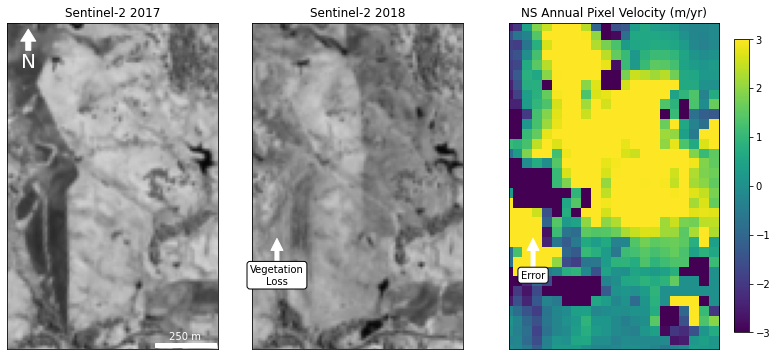

In [38]:
# Setup
b = 150
w, e, s, n = [bird.east.min()-b,bird.east.max()+b,bird.north.min()-b,bird.north.max()+b]

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(14,6),gridspec_kw={'width_ratios':[0.8,0.8,1]})

# Sentinel-2 2017
ax1.imshow(bird_2017,extent=extent_2017,interpolation=None,cmap='gray')

ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.1,color='white')
ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
ax1.set_title('Sentinel-2 2017')

# Sentinel-2 2017
ax2.imshow(bird_2018,extent=extent_2018,interpolation=None,cmap='gray')
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2.set_title('Sentinel-2 2018')

# NS pixel offset
ew_plot = ax3.imshow(po_bird_ew,extent=po_bird_extent,interpolation=None,vmin=-3,vmax=3)
ax3 = format_axis(ax3,xlim=(w,e),ylim=(s,n),show_axis=False)
ax3.set_title('NS Annual Pixel Velocity (m/yr)')

# an1 = ax3.annotate('Error', xy=(w+40, s+200), xycoords="data",
#                   va="center", ha="center",
#                   bbox=dict(boxstyle="round", fc="w"))

ax2.annotate('Vegetation\nLoss',xy=(w+100, s+450),
    xytext=(w+100, s+300), textcoords='data',
    va='center', ha='center',
    arrowprops = dict(color='white'),
    bbox=dict(boxstyle="round", fc="w"))

ax3.annotate('Error',xy=(w+100, s+450),
    xytext=(w+100, s+300), textcoords='data',
    va='center', ha='center',
    arrowprops = dict(color='white'),
    bbox=dict(boxstyle="round", fc="w"))

fig.colorbar(ew_plot, ax=ax3, shrink=0.9)
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(save_dir / 'pegs_error.png',dpi=300,bbox_inches='tight')

In [41]:
del bird_2017
del bird_2018
del po_bird_ew

### Figure Activity Examples

true positive 729, 846
false negative 746
false positive 147

In [9]:
landslide_active1, _, extent_active1 = read_raster('imagery/horizons_landslide_729.tif',bands=[1,2,3],rgb=True)
landslide_active2, _, extent_active2 = read_raster('imagery/horizons_landslide_846.tif',bands=[1,2,3],rgb=True)
landslide_active3, _, extent_active3 = read_raster('imagery/horizons_landslide_746.tif',bands=[1,2,3],rgb=True)
landslide_inactive, _, extent_inactive = read_raster('imagery/horizons_landslide_147.tif',bands=[1,2,3],rgb=True)
activity, _, extent_activity = read_raster('velcoh_combined_2019.tif',bands=1)

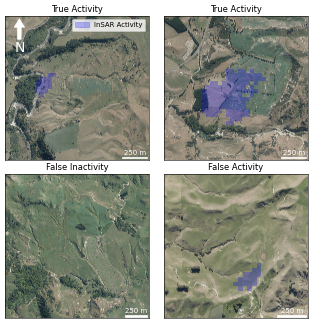

In [10]:
active_color = colors.to_rgba('blue',0.25)
acmap = colors.ListedColormap([(1,1,1,0),active_color])
f, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2,figsize=(8,8),dpi=50)

# Landslide 729
w,e,s,n = extent_active1
ax1.imshow(landslide_active1,extent=extent_active1)
ax1.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.2,color='white')
ax1.set_title('True Activity')

ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
patch = Patch(color=active_color, label='InSAR Activity')
ax1.legend(handles=[patch])

# Landslide 846
w,e,s,n = extent_active2
ax2.imshow(landslide_active2,extent=extent_active2)
ax2.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2 = add_scale_bar(ax2,width=250,label='250 m',color='white')
ax2.set_title('True Activity')

# Landslide 746
w,e,s,n = extent_active3
ax3.imshow(landslide_active3,extent=extent_active3)
ax3.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax3 = format_axis(ax3,xlim=(w,e),ylim=(s,n),show_axis=False)
ax3 = add_scale_bar(ax3,width=250,label='250 m',color='white')
ax3.set_title('False Inactivity')

# Landslide 846
w,e,s,n = extent_inactive
ax4.imshow(landslide_inactive,extent=extent_inactive)
ax4.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax4 = format_axis(ax4,xlim=(w,e),ylim=(s,n),show_axis=False)
ax4 = add_scale_bar(ax4,width=250,label='250 m',color='white')
ax4.set_title('False Activity')

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(save_dir / 'activity_examples.png',dpi=300,bbox_inches='tight')

In [11]:
del landslide_active1
del landslide_active2
del landslide_active3
del landslide_inactive
del activity

### Figure Activity Errors

In [6]:
coastal, _, extent_coastal = read_raster('imagery/horizons_coastal.tif',bands=[1,2,3],rgb=True)
riverbed, _, extent_riverbed = read_raster('imagery/horizons_riverbed.tif',bands=[1,2,3],rgb=True)
activity, _, extent_activity = read_raster('velcoh_combined_2019.tif',bands=1)

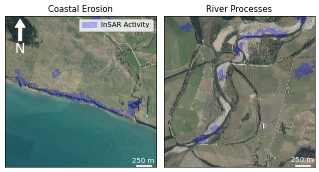

In [7]:
active_color = colors.to_rgba('blue',0.25)
acmap = colors.ListedColormap([(1,1,1,0),active_color])
f, [ax1,ax2] = plt.subplots(1,2,figsize=(8,4),dpi=50)

# Coastal Area
w,e,s,n = extent_coastal
ax1.imshow(coastal,extent=extent_coastal)
ax1.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax1 = format_axis(ax1,xlim=(w,e),ylim=(s,n),show_axis=False)
ax1 = add_north_arrow(ax1,x=0.1, y=0.98, arrow_length=0.2,color='white')
ax1.set_title('Coastal Erosion')

ax1 = add_scale_bar(ax1,width=250,label='250 m',color='white')
patch = Patch(color=active_color, label='InSAR Activity')
ax1.legend(handles=[patch])

# Landslide 846
w,e,s,n = extent_riverbed
ax2.imshow(riverbed,extent=extent_riverbed)
ax2.imshow(activity,extent=extent_activity,cmap=acmap,interpolation=None)
ax2 = format_axis(ax2,xlim=(w,e),ylim=(s,n),show_axis=False)
ax2 = add_scale_bar(ax2,width=250,label='250 m',color='white')
ax2.set_title('River Processes')

plt.subplots_adjust(wspace=0.05, hspace=0.1)
plt.savefig(save_dir / 'activity_errors.png',dpi=300,bbox_inches='tight')

In [8]:
del coastal
del riverbed
del activity

### Figure Study Area

In [39]:
centers = test_set.copy()
centers['geometry'] = centers.geometry.centroid
center_rang = centers.loc[centers.name == '155']
center_bird = centers.loc[centers.name == '230']
centers = centers.loc[~centers.name.isin(['155','230'])]
center_all= gpd.GeoSeries(geometry.box(*test_set.total_bounds).centroid)

nz_geo = gpd.read_file('bounds/nz-coastlines-and-islands-polygons-topo-150k.shp').simplify(0.001).to_crs(32760)
nz = gpd.GeoDataFrame({'area':nz_geo.geometry.area}, geometry=nz_geo.geometry)
nz = nz.sort_values('area',ascending=False).reset_index(drop=True).iloc[0:2]

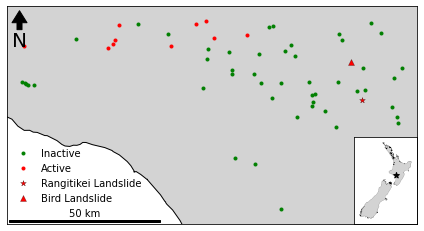

In [75]:
b = 5e3
w, s, e, n = centers.total_bounds

f, ax = plt.subplots(1,1,figsize=(12, 4))

ax = nz.plot(ax=ax,edgecolor='black',facecolor='lightgrey')
ax = centers.loc[centers.active==0].plot(ax=ax,marker='.',facecolor='green',legend=True,label='Inactive')
ax = centers.loc[centers.active==1].plot(ax=ax,marker='.',facecolor='red',legend=True,label='Active')
ax = center_rang.plot(ax=ax,marker='*',facecolor='red',edgecolor='black',linewidth=0.25,label='Rangitikei Landslide')
ax = center_bird.plot(ax=ax,marker='^',facecolor='red',edgecolor='black',linewidth=0.25,label='Bird Landslide')
ax.set_aspect('equal')
format_axis(ax,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

ax = add_north_arrow(ax,x=0.03, y=0.98, arrow_length=0.14,color='black')
ax = add_scale_bar(ax,width=50000,height=500,label='50 km',color='black',loc='lower left')
ax.legend(bbox_to_anchor=(0.35,0.39),frameon=False)

w, s, e, n = nz.total_bounds
b = 1e5
ax_inset = ax.inset_axes([0.7225,0.0,0.4,0.4])
ax_inset = nz.plot(ax=ax_inset,edgecolor='black',facecolor='lightgrey',linewidth=0.1)
ax_inset = center_all.plot(ax=ax_inset,color='black',marker='*')
ax_inset.set_aspect('equal')
format_axis(ax_inset,xlim=(w-b,e+b),ylim=(s-b,n+b),show_axis=False)

plt.savefig(save_dir / 'study_area.png',dpi=300,bbox_inches='tight')

### Figure N Ifgs

In [10]:
desc_n_ifgs, desc_intervals = get_zero_ifg_date_ranges(desc)
asc_n_ifgs, asc_intervals = get_zero_ifg_date_ranges(asc)

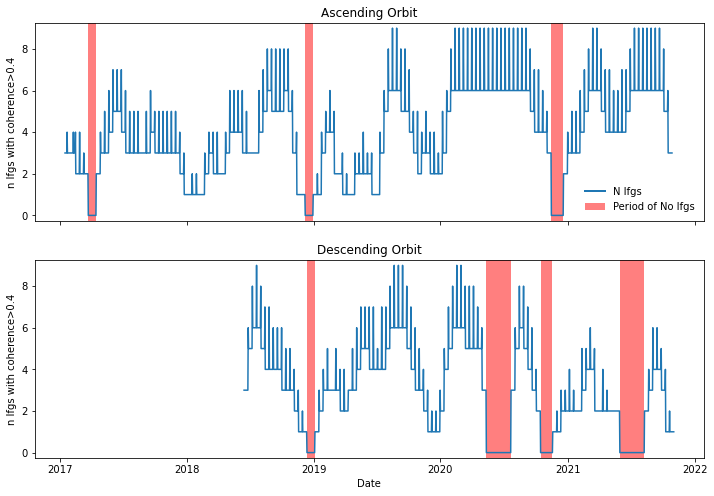

In [13]:
f, (ax1,ax2) = plt.subplots(2,1,figsize=(12,8),sharex=True,sharey=True)

# Ascending
ax1.plot(asc_n_ifgs.index,asc_n_ifgs.n_valid)
ax1.set(ylabel='n Ifgs with coherence>0.4',title='Ascending Orbit',ylim=(-0.25,9.25))
for i,row in asc_intervals.iterrows():
    ax1.add_patch(Rectangle((row.start, -1), row.length, 12,facecolor=(1,0,0,0.5)))

legend_elements = [Line2D([0],[0],lw=2,label='N Ifgs'),
                  Patch(facecolor=(1,0,0,0.5), label='Period of No Ifgs')]
ax1.legend(handles=legend_elements,frameon=False)

# Descending
ax2.plot(desc_n_ifgs.index,desc_n_ifgs.n_valid)
ax2.set(xlabel='Date',ylabel='n Ifgs with coherence>0.4',title='Descending Orbit',ylim=(-0.25,9.25))
for i,row in desc_intervals.iterrows():
    ax2.add_patch(Rectangle((row.start, -1), row.length, 12,facecolor=(1,0,0,0.5)))
    
plt.savefig(save_dir / 'n_ifgs.png',dpi=300,bbox_inches='tight')